In [1]:
import logging
import os
import random
import re

import gensim.corpora as corpora
from gensim.parsing.preprocessing import preprocess_string, \
strip_punctuation,remove_stopwords, strip_multiple_whitespaces,\
strip_short, strip_numeric
from gensim.models import CoherenceModel, LdaModel
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric,\
CoherenceMetric, DiffMetric
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load recipe data

In [2]:
recipe_file = "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/full_format_recipes.json"

In [3]:
recipe_df = pd.read_json(recipe_file, orient='records')
recipe_df.head(2)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0


In [4]:
# make a smaller sample for troubleshooting
# recipe_df = recipe_df[:500]

## Preprocess recipes

In [5]:
recipe_df = recipe_df.dropna(subset=['directions'])
recipe_df['joined_directions'] = [" ".join(steps) for steps in recipe_df.directions.tolist()]
recipe_df = recipe_df.drop_duplicates(subset="joined_directions", keep="first")
recipes = recipe_df.joined_directions.tolist()
titles = recipe_df.title.tolist()

# shuffle the recipes but retain a memory of the original index
recipes = [(i, r) for i, r in enumerate(recipes)]
random.seed(2)
random.shuffle(recipes)
recipe_indices = [item[0] for item in recipes]
recipe_text = [item[1] for item in recipes]
recipe_titles = [titles[i] for i in recipe_indices]

In [6]:
# tokenize, lowercase, remove punctuation, numbers, and stop words
CUSTOM_FILTERS = [lambda x: x.lower(),
                 strip_punctuation,
                 strip_numeric,
                 strip_short,
                 remove_stopwords,
                 strip_multiple_whitespaces]

preprocessed_recipes = [preprocess_string(recipe, CUSTOM_FILTERS)
                       for recipe in recipe_text]

In [7]:
len(preprocessed_recipes)

18097

In [8]:
# create dictionary
id2word = corpora.Dictionary(preprocessed_recipes)

# sample to produce training & validation sets 
train = preprocessed_recipes[:5000]
dev = preprocessed_recipes[5000:10000]

# compute term frequencies
train_corpus = [id2word.doc2bow(text) for text in train]
dev_corpus = [id2word.doc2bow(text) for text in dev]

In [9]:
# save dictionary and corpora
dict_save_path = "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/gensim_dict.dict"
id2word.save(dict_save_path)

train_corpus_path = "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/train.mm"
dev_corpus_path = "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/dev.mm"
corpora.MmCorpus.serialize(train_corpus_path, train_corpus) 
corpora.MmCorpus.serialize(dev_corpus_path, dev_corpus) 

## Functions for fitting & evaluation

In [10]:
def fit_model(corpus, id2word, num_topics, passes, iterations, 
              savefile, callbacks):
     model = LdaModel(corpus=corpus,
             id2word=id2word,
             num_topics=num_topics,
             passes=passes,
             iterations=iterations,
             callbacks=callbacks)
     model.save(savefile)

In [11]:
def collect_metrics(iterations, num_topics, outpath):
    """
    Get metrics from saved models.
    
    """
    all_metrics = pd.DataFrame()

    if isinstance(iterations, list):
        for iteration in iterations:
            model_name = f"lda_{iteration}"
            model_outpath = os.path.join(outpath, model_name)
            model_file = os.path.join(model_outpath, model_name + ".model")
            model = LdaModel.load(model_file)
            df = pd.DataFrame.from_dict(model.metrics)

            df['iterations'] = iteration
            df['topics'] = num_topics  

            df = df.reset_index().rename(columns={'index': 'pass_num'})

            all_metrics = pd.concat([all_metrics, df])
            
    elif isinstance(num_topics, list):
        for num_topic in num_topics:
            model_name = f"lda_{num_topic}"
            model_outpath = os.path.join(outpath, model_name)
            model_file = os.path.join(model_outpath, model_name + ".model")
            model = LdaModel.load(model_file)
            df = pd.DataFrame.from_dict(model.metrics)

            df['iterations'] = iterations
            df['topics'] = num_topic  

            df = df.reset_index().rename(columns={'index': 'pass_num'})

            all_metrics = pd.concat([all_metrics, df])
        
    return all_metrics
       
        
def plot_metrics_by_iteration(metrics, topic_num, plot_outpath=None):
    fig, axs = plt.subplots(3, 1, figsize=(8, 20))
    for i, metric in enumerate(['Coherence', 'Perplexity', 'Convergence',]):
        ax = axs[i]
        filtered_topics = metrics[metrics['topics'] == topic_num]
        for label, df in filtered_topics.groupby(['iterations']):
            df.plot(x='pass_num', y=metric, ax=ax, label=label)

        ax.set_xlabel(f"Pass number")
        ax.legend()
        ax.set_ylim([metrics[metric].min() * 0.9, metrics[metric].max() * 1.1])

        ax.set_title(metric, fontsize=10)
    if plot_outpath is not None:
        plot_file = os.path.join(plot_outpath, "metrics.png")
        plt.tight_layout()
        plt.savefig(plot_file)
        
    
def plot_metrics(metrics, hyperparameter, plot_outpath=None):
    fig, axs = plt.subplots(3, 1, figsize=(8, 20))
    for i, metric in enumerate(['Coherence', 'Perplexity', 'Convergence',]):
        ax = axs[i]
        for label, df in metrics.groupby([hyperparameter]):
            df.plot(x='pass_num', y=metric, ax=ax, label=label)

        ax.set_xlabel(f"Pass number")
        ax.legend()
        ax.set_ylim([metrics[metric].min() * 0.9, metrics[metric].max() * 1.1])

        ax.set_title(metric, fontsize=10)
    if plot_outpath is not None:
        plot_file = os.path.join(plot_outpath, "metrics.png")
        plt.tight_layout()
        plt.savefig(plot_file)
        
        
def get_top_docs(doc_topic_matrix, docs, num_docs, topics):
    top_docs = np.argsort(doc_topic_matrix, axis=0)[::-1][:num_docs]
    top_docs_text = [[docs[i] for i in rank] for rank in top_docs]
    doc_df = pd.DataFrame(top_docs_text)
    topics = [" ".join([w[0] for w in t[1]]) for t in topics]
    doc_df.columns = topics
    return doc_df

### Test how many passes & iterations are needed for convergence 

In [12]:
perplexity_callback = PerplexityMetric(corpus=dev_corpus, logger='shell')
convergence_callback = ConvergenceMetric(logger='shell')
diff_callback = DiffMetric(logger='shell')
coherence_cv_callback = CoherenceMetric(texts=dev, logger='shell', coherence = 'c_v')
callbacks=[convergence_callback, perplexity_callback, diff_callback, coherence_cv_callback]

In [30]:
outpath =  "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/lda_models_by_iteration_30_passes/"
if not os.path.exists(outpath):
    os.makedirs(outpath)

iterations = [50, 100, 150]

num_topics = 10

passes = 30

for iteration in iterations:
    model_name = f"lda_{iteration}"
    model_outpath = os.path.join(outpath, model_name)
    if not os.path.exists(model_outpath):
        os.makedirs(model_outpath)
    modelfile = os.path.join(model_outpath, model_name + ".model")
    fit_model(train_corpus, id2word, num_topics, passes, iteration, 
              modelfile, callbacks)

In [31]:
metrics = collect_metrics(iterations, num_topics, outpath)

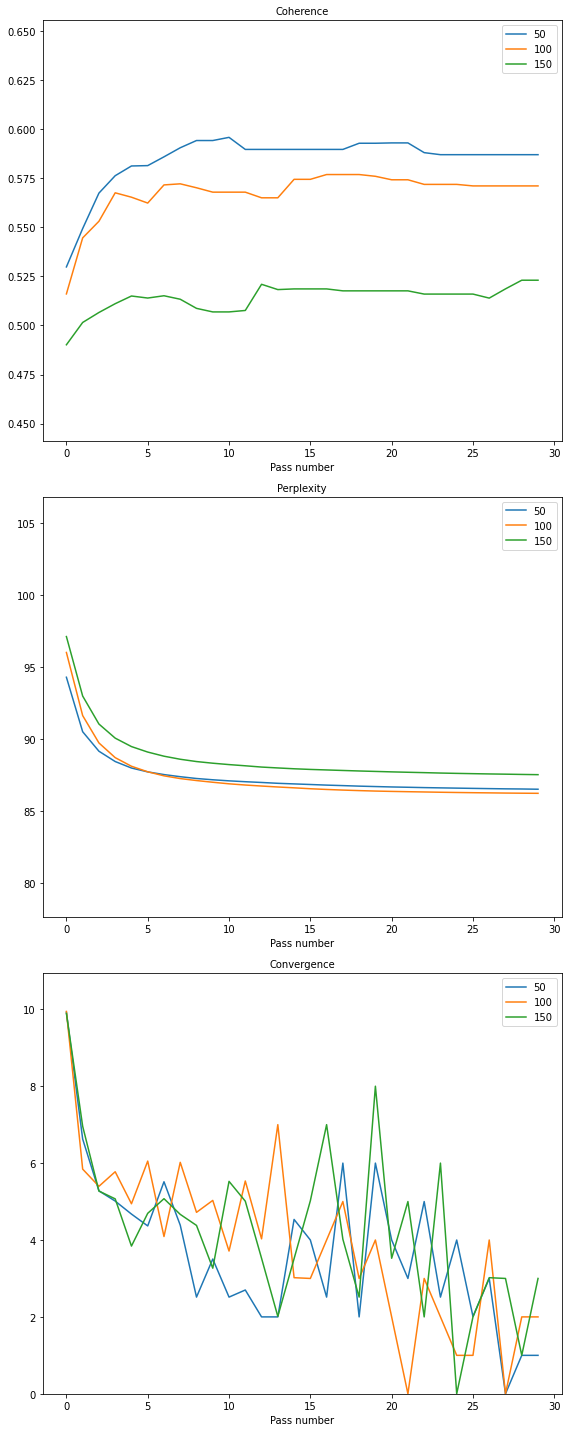

In [32]:
plot_metrics(metrics, 'iterations', outpath)

## Coherence is best with 50 iterations; 10 passes looks like enough 

## Tune the number of topics

In [13]:
outpath =  "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/lda_50_iter_num_topics_redo/"
if not os.path.exists(outpath):
    os.makedirs(outpath)
    
num_topics_list = [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
iterations = 50
passes = 10

for num_topics in num_topics_list:
    model_name = f"lda_{num_topics}"
    model_outpath = os.path.join(outpath, model_name)
    if not os.path.exists(model_outpath):
        os.makedirs(model_outpath)
    modelfile = os.path.join(model_outpath, model_name + ".model")
    fit_model(train_corpus, id2word, num_topics, passes, iterations, 
              modelfile, callbacks)

/Users/Carol/opt/anaconda3/envs/food/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/Users/Carol/opt/anaconda3/envs/food/lib/python3.6/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
/Users/Carol/opt/anaconda3/envs/food/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/Users/Carol/opt/anaconda3/envs/food/lib/python3.6/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


In [13]:
outpath =  "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/lda_50_iter_num_topics/"
num_topics_list = [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
iterations = 50
metrics = collect_metrics(iterations, num_topics_list, outpath)


In [39]:
metrics.head()

,pass_num,Convergence,Perplexity,Diff,Coherence,iterations,topics
0,0,5.959544,91.484058,"[0.98989898989899, 1.0, 0.9949748743718593, 1....",0.510023,50,6
1,1,3.230373,88.334258,"[1.0, 0.18242207460398563, 0.7205402887750351,...",0.499536,50,6
2,2,3.361738,86.886248,"[1.0, 0.2531740104555637, 0.7902097902097899, ...",0.522596,50,6
3,3,2.970097,86.107691,"[0.9082568807339453, 0.0, 1.0, 0.4230769230769...",0.525491,50,6
4,4,3.206723,85.650633,"[0.8652291105121291, 0.29971988795518184, 0.44...",0.541170,50,6


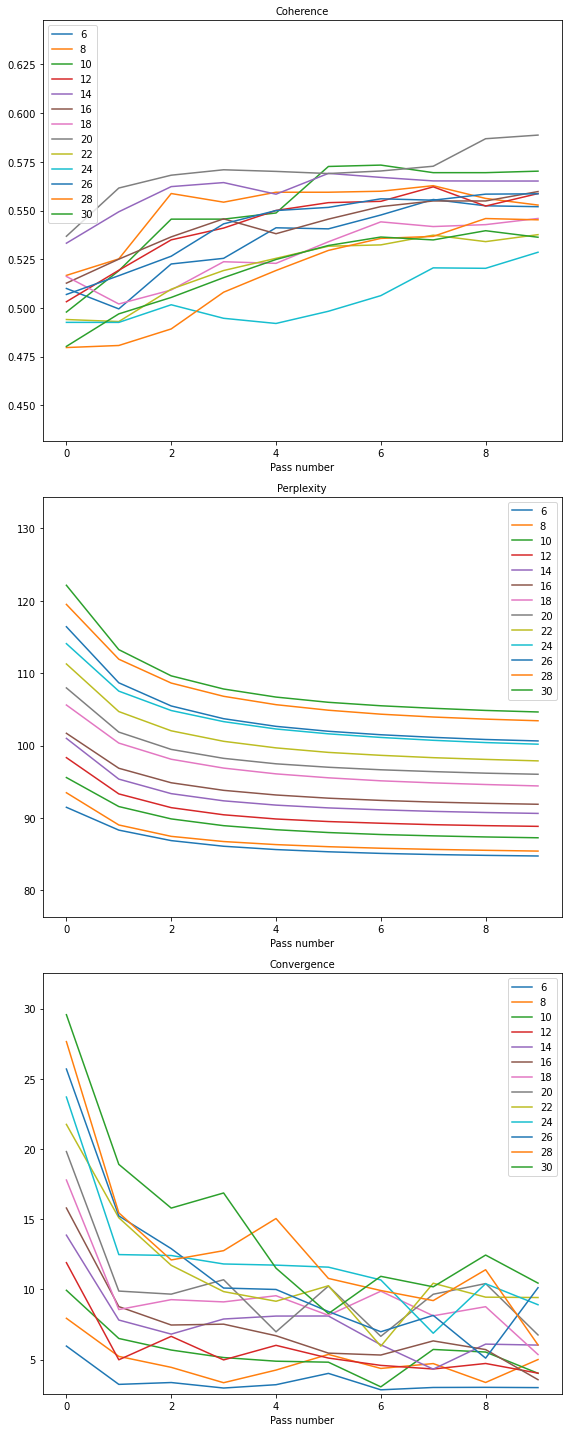

In [14]:
plot_metrics(metrics, 'topics', outpath)

In [17]:
max_coherence = pd.DataFrame(metrics.groupby('topics')['Coherence'].max())
max_coherence

,Coherence
topics,
6,0.555691
8,0.562786
10,0.573353
12,0.562190
14,0.569097
16,0.559766
18,0.545960
20,0.588753
22,0.537646


/Users/Carol/opt/anaconda3/envs/food/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='topics', ylabel='Coherence'>

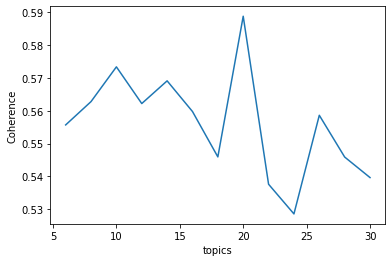

In [23]:
# max coherence vs. topic number
sns.lineplot(max_coherence.index, max_coherence.Coherence)

# Troubleshoot extracting example docs 

In [14]:
outpath =  "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/lda_troubleshooting_2/"
if not os.path.exists(outpath):
    os.makedirs(outpath)
    
num_topics_list = [10]
iterations = 50
passes = 10

for num_topics in num_topics_list:
    model_name = f"lda_{num_topics}"
    model_outpath = os.path.join(outpath, model_name)
    if not os.path.exists(model_outpath):
        os.makedirs(model_outpath)
    modelfile = os.path.join(model_outpath, model_name + ".model")
    fit_model(train_corpus, id2word, num_topics, passes, iterations, 
              modelfile, callbacks)

In [2]:
# reload corpora, dictionary, and model
dict_save_path = "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/gensim_dict.dict"
id2word = corpora.Dictionary.load(dict_save_path)

train_corpus_path = "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/train.mm"
dev_corpus_path = "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/dev.mm"
train_corpus = corpora.MmCorpus(train_corpus_path)
dev_corpus = corpora.MmCorpus(dev_corpus_path)

model_path = "/Users/Carol/Dropbox/epicurious-recipes-with-rating-and-nutrition/lda_troubleshooting_2/lda_10/lda_10.model"
model = LdaModel.load(model_path)

In [3]:
new_topics = model.show_topics(num_topics=10, formatted=False)
new_topics

[(0,
  [('sugar', 0.027196288),
   ('mixture', 0.023903152),
   ('heat', 0.022590319),
   ('bowl', 0.021951035),
   ('medium', 0.018480705),
   ('saucepan', 0.017469155),
   ('cream', 0.017432764),
   ('minutes', 0.017191604),
   ('cup', 0.017019229),
   ('stir', 0.01286479)]),
 (1,
  [('dough', 0.020604191),
   ('minutes', 0.020268226),
   ('bowl', 0.017719636),
   ('inch', 0.015665142),
   ('butter', 0.013893151),
   ('oven', 0.013451338),
   ('pan', 0.013272075),
   ('mixture', 0.013199314),
   ('baking', 0.012841684),
   ('flour', 0.012189955)]),
 (2,
  [('oven', 0.034381438),
   ('minutes', 0.0258256),
   ('baking', 0.024893282),
   ('preheat', 0.020000063),
   ('sheet', 0.016125996),
   ('salt', 0.013923216),
   ('bake', 0.012935396),
   ('remaining', 0.012435656),
   ('inch', 0.011975246),
   ('dish', 0.011568151)]),
 (3,
  [('pan', 0.037249077),
   ('turkey', 0.033491686),
   ('juices', 0.020023368),
   ('roasting', 0.01855048),
   ('minutes', 0.017863493),
   ('fat', 0.0172437

In [5]:
def get_doc_topic_matrix(model, corpus, num_topics):
    """
    Get a matrix of shape (# docs, # topics) from a reloaded
    Gensim model and a given Gensim corpus. This can be used to 
    retrieve the top documents for each topic.
    """
    doc_topic_list = model[corpus]
    doc_topic_matrix = np.zeros((len(corpus), num_topics))
    for i, doc in enumerate(doc_topic_list):
        for item in doc:
            doc_topic_matrix[i, item[0]] = item[1]
    return doc_topic_matrix


dt = get_doc_topic_matrix(model, train_corpus, 10)

In [6]:
dt.shape

(5000, 10)

In [14]:
get_top_docs(dt, recipe_text, 10, new_topics)

,sugar mixture heat bowl medium saucepan cream minutes cup stir,dough minutes bowl inch butter oven pan mixture baking flour,oven minutes baking preheat sheet salt bake remaining inch dish,pan turkey juices roasting minutes fat roast add stuffing butter,place water set pan remove use hot time ready aside,add minutes pepper large salt medium bowl heat season cover,grill minutes bowl salt oil cut pepper medium let lamb,chicken juice glass lemon combine pour ice add ingredients stir,water minutes cook add heat stirring pot drain simmer boil,heat minutes add skillet cook oil salt sauce medium pepper
0,Stir cheryy juices and sugar in medium saucepa...,Whisk flour and salt in medium bowl to blend w...,Preheat oven to 450°F. Using small sharp knife...,Position rack in bottom third of oven and preh...,Place the dates in a large bowl. Pour the wate...,Melt butter in heavy large skillet over medium...,Preheat broiler. Spray broiler pan with nonsti...,"Stir 3 tablespoons Simple Syrup, 2 tablespoons...",Bring broth and water to a simmer in a 2 1/2- ...,"In a large dry skillet over medium heat, light..."
1,"Combine 1 cup blackberries, sugar and water in...","Blend flour, cake flour, sugar and salt in pro...",Preheat oven to 500°F and put a large shallow ...,Preheat oven to 325°F. Rinse turkey inside and...,Open vents on bottom of grill. Light a large c...,Cook lima beans in large pot of boiling salted...,In a bowl whisk together the vinegar and salt ...,"Combine vodka, apricot brandy, Campari, lemon ...",In a saucepan bring the water to a boil with t...,Mince 1 garlic clove and mash to a paste with ...
2,Puree raspberries in processor until almost sm...,"Whisk flour, cocoa and baking powder in small ...",Put oven rack in middle position and preheat o...,Preheat oven to 350°F. Rinse turkey inside and...,"To prepare a water bath for baking, put your f...",Place shrimp in medium bowl; sprinkle with sal...,Prepare grill for direct-heat cooking over hot...,"In a blender, blend banana, orange juice, lime...",Halve leeks lengthwise and cut enough crosswis...,In a skillet heat the oil over moderately high...
3,"Combine 1 1/2 cups heavy cream, 1 cup whole mi...",Whisk both flours and salt in bowl. Using elec...,Preheat oven to 350°F. Cut top 1/4 inch off he...,Preheat oven to 450°F. Set a rack inside a lar...,"Cut slices from very good, crusty white bread....",Melt butter in heavy medium saucepan over medi...,Mix first 7 ingredients in large glass baking ...,In mixing glass or cocktail shaker filled with...,Chop bacon and in a large heavy saucepan cook ...,Boil both stocks in medium saucepan until redu...
4,Mix cream and milk in heavy large saucepan. Sc...,Put oven rack in middle position and preheat o...,Preheat oven to 375°F. Combine first 11 ingred...,Pat turkey dry. Run hands under skin of turkey...,Measure the cold soy milk in a quart-size pitc...,"Blend egg yolks, lemon juice, and mustard powd...",Cut trimmed lamb into 1 1/4- to 1 1/2-inch cub...,"Combine all ingredients, except the orange pee...","In a kettle combine the potatoes, peeled and h...",Heat 2 tablespoons oil in a 12-inch heavy skil...
5,"Combine cream, milk, and sugar in a medium sau...","Stir 1 1/2 teaspoons lukewarm milk, 1 1/2 teas...","Using back of fork, mash cheese and crème fraî...",Rub salt and clementine peel together in small...,1. Combine all the ingredients except the wine...,Cook orzo in large pot of boiling salted water...,Lightly pierce steaks all over with a sharp fo...,"Into a chilled Champagne glass, pour orange ju...",Cook pasta in a 6- to 8-quart pot of boiling s...,Melt 1 tablespoon butter in medium skillet ove...
6,"Stir chocolate, 1/3 cup cream, 1/3 cup water a...",Pulse figs and raisins in a food processor unt...,Preheat oven to 350°F. Oil 13 x 9 x 2-inch gla...,Line extra-large stockpot with heavy large pla...,Line a rimmed baking sheet with parchment pape...,Melt butter in heavy large pot over medium-hig...,Prepare grill. Pit olives and coarsely chop. I.

In [15]:
get_top_docs(dt, recipe_titles, 5, new_topics)    

,sugar mixture heat bowl medium saucepan cream minutes cup stir,dough minutes bowl inch butter oven pan mixture baking flour,oven minutes baking preheat sheet salt bake remaining inch dish,pan turkey juices roasting minutes fat roast add stuffing butter,place water set pan remove use hot time ready aside,add minutes pepper large salt medium bowl heat season cover,grill minutes bowl salt oil cut pepper medium let lamb,chicken juice glass lemon combine pour ice add ingredients stir,water minutes cook add heat stirring pot drain simmer boil,heat minutes add skillet cook oil salt sauce medium pepper
0,Chocolate and Vanilla Parfaits with Cherry Sauce,Tea Cake Sandwich Cookies,Roasted Beef Tenderloin Wrapped in Bacon,Roast Turkey with White Wine Gravy,Date Paste,Succotash Soup with Black Pepper Croutons,Lamb Tikka with Crispy Onions,Raspberry Shrub,Radicchio and Red-Wine Rissoto,"Sausage with Sauerkraut, Apples, and Bok Choy"
1,White Chocolate-Blackberry Parfait,Golden Raisin and Apple Lattice Pie,Garlic-Roasted Striped Bass,Roast Turkey with Sherry Wine Vinegar Gravy,Gourmet Magazine Grilling Procedures,Southwestern Succotash,Grilled Vegetables on Onion Rolls,Silver Sunset,Soba Soup with Spinach and Tofu,"Veal Chop with Radicchio, White Beans, and Ros..."
2,Lemon Ice Cream and Raspberry Granita Sundaes,Cocoa-Peanut Butter Heart-Shaped Sandwich Cook...,Lobster Claw Toasts,Red Currant-Glazed Turkey with Sage and Red Cu...,To Prepare a Water Bath for Baking,Linguine with Shrimp and Plum Tomatoes,Grilled Skirt Steak and Arugula Salad with Roq...,Orange Banana Shake,Curried Potato and Leek Soup with Spinach,Lamb Chops with Mushroom Wine Sauce
3,True Vanilla Ice Cream,"Pumpkin, Ginger and Molasses Tart",Roasted Garlic,A Simple Roast Turkey,Victor's Parmesan and Olive Oil Crostino,Quick Shrimp Bisque,"Grilled Lamb Chops with Red Wine, Garlic and H...",Manhattan,Cheddar Potato Soup with Bacon,Veal Scaloppine with Gorgonzola Sauce
4,Mincemeat Ice Cream,Pecan Spice Layer Cake with Cream Cheese Frost...,Beef and Sausage Meat Loaf with Mozzarella,"Roast Turkey with Prosciutto, Rosemary and Gar...",Steamed Soy Milk Custard,Poached Arctic Char with Basil-Tarragon Mayonn...,Greek Lamb Brochettes with Cucumber and Tomato...,Spencer,Purée of Three Root Vegetables,Pork Chops with Golden Onions and Wilted Tomat...


In [ ]:
## Tune alpha and beta

In [ ]:
# lda_model = LdaModel(corpus=corpus,
#                        id2word=id2word,
#                        num_topics=10, 
#                        passes=1,
#                        eval_every=20,
#                        callbacks=[convergence_logger, perplexity_logger, coherence_cv_logger])

In [ ]:
# # compute Coherence Score using c_v
# coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_recipes, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [ ]:
# # Compute Coherence Score using UMass
# coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_recipes, dictionary=id2word, coherence="u_mass")
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [ ]:
# lda_model.show_topics()

In [ ]:
# models, scores = compute_coherence_values(id2word, corpus, preprocessed_recipes,
#                                          10, 2, 2)

In [ ]:
# save
dictionary.save(DICT_PATH)
corpora.MmCorpus.serialize(CORPUS_PATH, corpus)

loaded_dict = corpora.Dictionary.load(DICT_PATH)
loaded_corp = corpora.MmCorpus(CORPUS_PATH)